In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

import joblib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scripts import utils
VECTORIZER_PATH = utils.get_datapath('vectorizer_data')

%load_ext autoreload
%autoreload 2

# **Spotify Popularity Classification**

## Predicting Popularity Using Logistic Regression
### Bag of Words
We will try to use logistic regression with default parameters to predict whether a song will be popular or not.
This prediction will utilize a bag of words representation of the lyrics.

In [2]:
X_train, X_test, y_train, y_test = utils.load_transformed_data('bag_of_words_two_class')

In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30324, 2217), (7581, 2217), (30324,), (7581,))

In [4]:
type(X_train), type(X_test), type(y_train), type(y_test)

(scipy.sparse._csr.csr_matrix,
 scipy.sparse._csr.csr_matrix,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [5]:

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)


/home/jng/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [6]:
print(log_reg.score(X_train, y_train))

0.66798575385833


We can see that this model did not converge and was unable to minimize the cost function. This explains its poor performance for the training data. The default solver `lbfgs` might not be suitable for this dataset. 

We will try the `newton-cholesky` solver as the number of samples is much larger than the number of features.

In [7]:
log_reg = LogisticRegression(solver='newton-cholesky')
log_reg.fit(X_train, y_train)
print(f'Train Accuracy: {log_reg.score(X_train, y_train)}')

Train Accuracy: 0.6662709405091677


In [8]:
print(f'Test Accuracy: {log_reg.score(X_test, y_test)}')

Test Accuracy: 0.5964912280701754


This solver lets the model converge and provides a test accuracy of 66.6% and a train accuracy of 59.6%

We will try to improve this model by using L2 regularization. This is the only regularization that works with the `newton-cholesky` solver. Additionally we will try various C values to see how the accuracy changes.

In [9]:
c_range = [
    (1/10)**n
    for n in np.arange(0,10,0.5)
]

train_accuracy = []
test_accuracy = []

for c in c_range:
    log_reg = LogisticRegression(penalty='l2', C=c, solver='newton-cholesky')
    log_reg.fit(X_train, y_train)
    train_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))



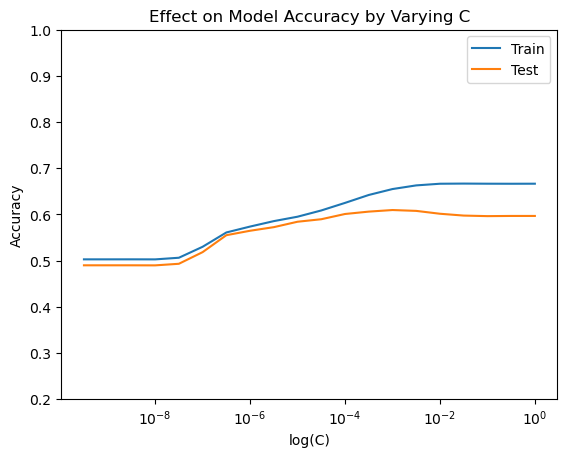

In [14]:
plt.figure()
plt.title('Effect on Model Accuracy by Varying C')
plt.plot(c_range, train_accuracy, label='Train')
plt.plot(c_range, test_accuracy, label='Test')
plt.xscale('log')
plt.xlabel('log(C)')
plt.ylabel('Accuracy')
plt.ylim(0.2,1)
plt.legend()
plt.show()

In [15]:
print(f'Max Accuracy Train: {train_accuracy[np.argmax(train_accuracy)]}')
print(f'C: {c_range[np.argmax(train_accuracy)]}')

print(f'Max Accuracy Test: {test_accuracy[np.argmax(test_accuracy)]}')
print(f'C: {c_range[np.argmax(test_accuracy)]}')

Max Accuracy Train: 0.6665347579475003
C: 0.0316227766016838
Max Accuracy Test: 0.6092863738293102
C: 0.0010000000000000002


We see that we get a peak test accuracy of approximately 60.9% with our logistic regression where we used an l2 regularization with an $\alpha = 1000$ 

This is a slight improvement over our initial model, where no regularization was used.

### TF-IDF

In [2]:
X_train, X_test, y_train, y_test = utils.load_transformed_data('tf_idf_two_class')

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(X_test), type(y_train), type(y_test))

(30324, 2211) (7581, 2211) (30324,) (7581,)
<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [3]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
print(f'Train Accuracy: {log_reg.score(X_train, y_train)}')
print(f'Test Accuracy: {log_reg.score(X_test, y_test)}')

Train Accuracy: 0.6635008574066745
Test Accuracy: 0.6005803983643319


In [4]:
c_range = [
    (1/10)**n
    for n in np.arange(0,10,0.5)
]

train_accuracy = []
test_accuracy = []

for c in c_range:
    log_reg = LogisticRegression(penalty='l2', C=c, solver='newton-cholesky')
    log_reg.fit(X_train, y_train)
    train_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))

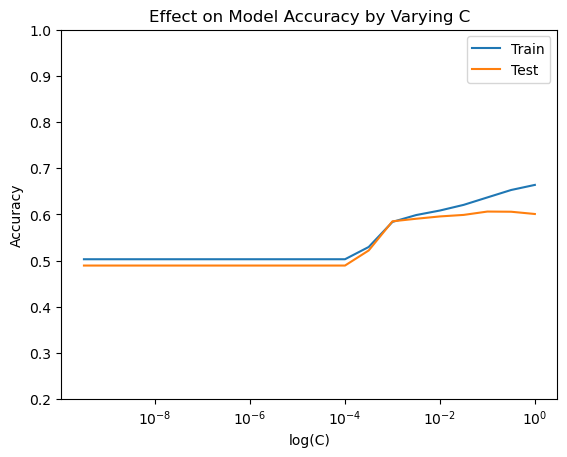

In [6]:
plt.figure()
plt.title('Effect on Model Accuracy by Varying C')
plt.plot(c_range, train_accuracy, label='Train')
plt.plot(c_range, test_accuracy, label='Test')
plt.xscale('log')
plt.xlabel('log(C)')
plt.ylabel('Accuracy')
plt.ylim(0.2,1)
plt.legend()
plt.show()

In [5]:
print(f'Max Accuracy Train: {train_accuracy[np.argmax(train_accuracy)]}')
print(f'C: {c_range[np.argmax(train_accuracy)]}')

print(f'Max Accuracy Test: {test_accuracy[np.argmax(test_accuracy)]}')
print(f'C: {c_range[np.argmax(test_accuracy)]}')

Max Accuracy Train: 0.6636657433056325
C: 1.0
Max Accuracy Test: 0.6059886558501517
C: 0.1


### 2-Grams Bag of Words

In [34]:
X_train, X_test, y_train, y_test = utils.load_transformed_data('2_grams_two_class')

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(X_test), type(y_train), type(y_test))

(30324, 404) (7581, 404) (30324,) (7581,)
<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [35]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
print(f'Train Accuracy: {log_reg.score(X_train, y_train)}')
print(f'Test Accuracy: {log_reg.score(X_test, y_test)}')

Train Accuracy: 0.5772655322516819
Test Accuracy: 0.5595567867036011


In [36]:
c_range = [
    (1/10)**n
    for n in np.arange(0,10,0.5)
]

train_accuracy = []
test_accuracy = []

for c in c_range:
    log_reg = LogisticRegression(penalty='l2', C=c, solver='newton-cholesky')
    log_reg.fit(X_train, y_train)
    train_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))

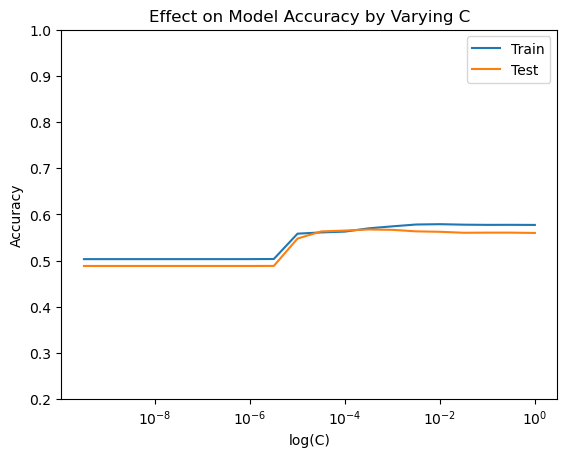

In [37]:
plt.figure()
plt.title('Effect on Model Accuracy by Varying C')
plt.plot(c_range, train_accuracy, label='Train')
plt.plot(c_range, test_accuracy, label='Test')
plt.xscale('log')
plt.xlabel('log(C)')
plt.ylabel('Accuracy')
plt.ylim(0.2,1)
plt.legend()
plt.show()

In [38]:
print(f'Max Accuracy Train: {train_accuracy[np.argmax(train_accuracy)]}')
print(f'C: {c_range[np.argmax(train_accuracy)]}')

print(f'Max Accuracy Test: {test_accuracy[np.argmax(test_accuracy)]}')
print(f'C: {c_range[np.argmax(test_accuracy)]}')

Max Accuracy Train: 0.5786505738029284
C: 0.010000000000000002
Max Accuracy Test: 0.5672074924152486
C: 0.000316227766016838


# 3-Grams Bag of Words

In [39]:
X_train, X_test, y_train, y_test = utils.load_transformed_data('3_grams_two_class')

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(X_test), type(y_train), type(y_test))

(30324, 717) (7581, 717) (30324,) (7581,)
<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [40]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
print(f'Train Accuracy: {log_reg.score(X_train, y_train)}')
print(f'Test Accuracy: {log_reg.score(X_test, y_test)}')

Train Accuracy: 0.562260915446511
Test Accuracy: 0.541881018335312


/home/jng/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
c_range = [
    (1/10)**n
    for n in np.arange(0,10,0.5)
]

train_accuracy = []
test_accuracy = []

for c in c_range:
    log_reg = LogisticRegression(penalty='l2', C=c, solver='newton-cholesky')
    log_reg.fit(X_train, y_train)
    train_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))

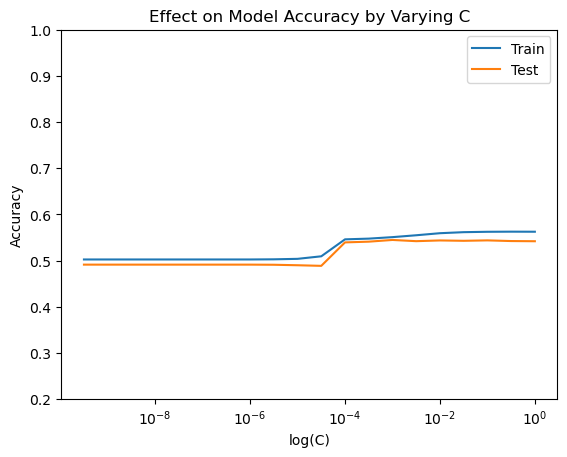

In [42]:
plt.figure()
plt.title('Effect on Model Accuracy by Varying C')
plt.plot(c_range, train_accuracy, label='Train')
plt.plot(c_range, test_accuracy, label='Test')
plt.xscale('log')
plt.xlabel('log(C)')
plt.ylabel('Accuracy')
plt.ylim(0.2,1)
plt.legend()
plt.show()

In [43]:
print(f'Max Accuracy Train: {train_accuracy[np.argmax(train_accuracy)]}')
print(f'C: {c_range[np.argmax(train_accuracy)]}')

print(f'Max Accuracy Test: {test_accuracy[np.argmax(test_accuracy)]}')
print(f'C: {c_range[np.argmax(test_accuracy)]}')

Max Accuracy Train: 0.5624587785252605
C: 0.31622776601683794
Max Accuracy Test: 0.5445191927186387
C: 0.0010000000000000002


## Predicting Multi-class Popularity
### Bag of Words
Next we will look at how logistic regression performs with a multi-class classification, where we classify popularity in high, medium and low popularity. We will try with the default solver and then try all the solvers that can be used for multi class and see which one performs best.

In [12]:
X_train, X_test, y_train, y_test = utils.load_transformed_data('bag_of_words_three_class')

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(X_test), type(y_train), type(y_test))

(30324, 2217) (7581, 2217) (30324,) (7581,)
<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [13]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
print(f'Train Accuracy: {log_reg.score(X_train, y_train)}')
print(f'Test Accuracy: {log_reg.score(X_test, y_test)}')

Train Accuracy: 0.5270083102493075
Test Accuracy: 0.4182825484764543


/home/jng/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We can see that the default solver once again failed to converge. We will now move on to the other solvers and also increase the `max_iter` to 10000 to try and get the model to converge.

In [14]:
for solver in ['newton-cg', 'sag', 'saga']:
    log_reg = LogisticRegression(solver=solver, max_iter=10000)
    log_reg.fit(X_train, y_train)
    print(f'\nSolver: {solver}')
    print(f'Train Accuracy: {log_reg.score(X_train, y_train)}')
    print(f'Test Accuracy: {log_reg.score(X_test, y_test)}')


Solver: newton-cg
Train Accuracy: 0.5269753330695159
Test Accuracy: 0.41735918744228995

Solver: sag
Train Accuracy: 0.5254583827991031
Test Accuracy: 0.4128742909906345

Solver: saga
Train Accuracy: 0.524271204326606
Test Accuracy: 0.40984039044980874
